In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# **Spliting dataset**

In [2]:
(x_train, _),(x_test,_)= mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


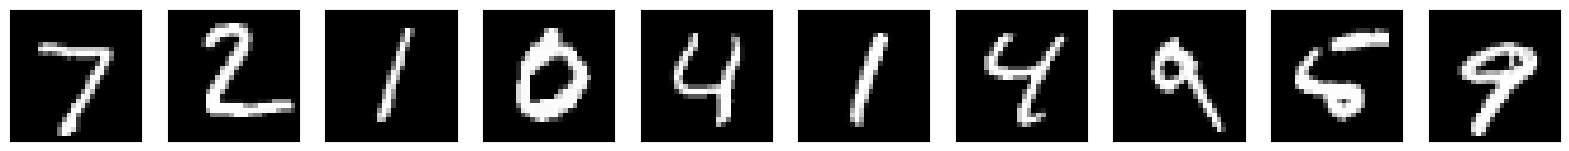

In [5]:
n=10 # no of classes
plt.figure(figsize=(20,4))
for i in range(n):
  ax= plt.subplot(1,n,i+1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [6]:
x_train= x_train.astype('float32')/255
x_test= x_test.astype('float32')/255
x_train=x_train.reshape(len(x_train),28*28*1)
x_test= x_test.reshape(len(x_test),28*28*1)
print("Shape of x_train: ", x_train.shape)
print("Shape of x_test: ", x_test.shape)

Shape of x_train:  (60000, 784)
Shape of x_test:  (10000, 784)


# **AutoEncode using CNN**

In [8]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from tensorflow.keras.models import Model

# **Architecture of AutoEncoder**

In [12]:
input_conv= Input(shape=(28,28,1))

x= Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal', activation='relu')(input_conv)
x= MaxPooling2D((2,2),padding='same')(x)

x= Conv2D(32,(3,3),padding='same', activation='relu')(x)
x= MaxPooling2D((2,2),padding='same')(x)

x= Conv2D(4,(3,3),padding='same', activation='relu')(x)
x= MaxPooling2D((2,2),padding='same')(x)

code= Flatten(name='bot')(x)

y=Reshape((4,4,4),input_shape=(64,),name='botnext0')(code)
y= Conv2D(4,(3,3),padding='same', activation='relu',name='botnext1')(y)
y= UpSampling2D((2,2), name='botnext2')(y)

y= Conv2D(32,(3,3),padding='same', activation='relu',name='botnext3')(y)
y= UpSampling2D((2,2), name='botnext4')(y)


y= Conv2D(32,(3,3),padding='valid', activation='relu',name='botnext5')(y)
y= UpSampling2D((2,2), name='botnext6')(y)

y= Conv2D(1,(3,3),padding='same', activation='sigmoid',name='botnext7')(y)
Ae_conv= Model(inputs = input_conv, outputs=y )

Ae_conv.compile(optimizer=tf.keras.optimizers.SGD(0.09,clipvalue=2.5), loss='binary_crossentropy', metrics=['accuracy'])
Ae_conv.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 4)           1156  

# **Encoder**

In [13]:
encoder= Model(inputs= input_conv, outputs=Ae_conv.get_layer('bot').output, name='Encoder_of_AutoEncoder')
encoder.summary()

Model: "Encoder_of_AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 4)

# **Decoder**

In [14]:
encoded_input= Input(shape=(64,))
temp_decoder=Ae_conv.get_layer('botnext0')(encoded_input)
for i in range(1,8):
  st="botnext{}".format(i)
  temp_decoder= Ae_conv.get_layer(st)(temp_decoder)

ae_decoder= Model(inputs=encoded_input, outputs= temp_decoder, name='AutoEncoder_Decoder' )
ae_decoder.summary()

Model: "AutoEncoder_Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64)]              0         
                                                                 
 botnext0 (Reshape)          (None, 4, 4, 4)           0         
                                                                 
 botnext1 (Conv2D)           (None, 4, 4, 4)           148       
                                                                 
 botnext2 (UpSampling2D)     (None, 8, 8, 4)           0         
                                                                 
 botnext3 (Conv2D)           (None, 8, 8, 32)          1184      
                                                                 
 botnext4 (UpSampling2D)     (None, 16, 16, 32)        0         
                                                                 
 botnext5 (Conv2D)           (None, 14, 14, 32)

# **Reshaping**

In [15]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# **Training AutoEncoder**

In [16]:
from time import time
tic= time()

Ae_conv.fit(x_train, x_train,
     batch_size=64,
    epochs= 100, verbose=2,
    validation_split=0.2,
            shuffle=False
)

toc= time()
print("Training took {} Secs".format(toc-tic))

Epoch 1/100
750/750 - 15s - loss: 0.2175 - accuracy: 0.7939 - val_loss: 0.1851 - val_accuracy: 0.8067 - 15s/epoch - 20ms/step
Epoch 2/100
750/750 - 4s - loss: 0.1633 - accuracy: 0.7984 - val_loss: 0.1634 - val_accuracy: 0.8068 - 4s/epoch - 5ms/step
Epoch 3/100
750/750 - 4s - loss: 0.1478 - accuracy: 0.8018 - val_loss: 0.1500 - val_accuracy: 0.8079 - 4s/epoch - 5ms/step
Epoch 4/100
750/750 - 4s - loss: 0.1388 - accuracy: 0.8039 - val_loss: 0.1396 - val_accuracy: 0.8093 - 4s/epoch - 5ms/step
Epoch 5/100
750/750 - 4s - loss: 0.1326 - accuracy: 0.8054 - val_loss: 0.1340 - val_accuracy: 0.8101 - 4s/epoch - 6ms/step
Epoch 6/100
750/750 - 4s - loss: 0.1279 - accuracy: 0.8065 - val_loss: 0.1318 - val_accuracy: 0.8110 - 4s/epoch - 6ms/step
Epoch 7/100
750/750 - 4s - loss: 0.1245 - accuracy: 0.8073 - val_loss: 0.1286 - val_accuracy: 0.8115 - 4s/epoch - 5ms/step
Epoch 8/100
750/750 - 3s - loss: 0.1217 - accuracy: 0.8080 - val_loss: 0.1184 - val_accuracy: 0.8104 - 3s/epoch - 5ms/step
Epoch 9/100
7

# **Saving the model**

In [19]:
Ae_conv.save('mnist_autoencoder_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model_deploy=keras.models.load_model("/content/mnist_autoencoder_cnn.h5")

In [22]:
model_deploy.predict(x_test)

313/313 [==============================] - 1s 2ms/step


array([[[[1.8279818e-04],
         [2.5423103e-06],
         [6.0255263e-07],
         ...,
         [4.6951609e-10],
         [7.0378997e-10],
         [9.7279859e-08]],

        [[2.7942133e-07],
         [2.0240265e-09],
         [2.3999525e-10],
         ...,
         [1.2522606e-12],
         [2.3232924e-11],
         [8.9133081e-08]],

        [[7.0134242e-08],
         [1.0027821e-09],
         [1.3038562e-10],
         ...,
         [4.8727845e-12],
         [1.1875166e-10],
         [4.9980628e-08]],

        ...,

        [[2.2517013e-06],
         [7.5354905e-09],
         [1.6209245e-10],
         ...,
         [5.9363831e-10],
         [2.8724396e-09],
         [9.0124911e-07]],

        [[4.8585807e-06],
         [1.7225009e-08],
         [5.5142785e-10],
         ...,
         [6.5138406e-09],
         [4.7597254e-08],
         [7.5220692e-06]],

        [[2.1109363e-05],
         [4.2127834e-07],
         [2.8853448e-08],
         ...,
         [8.0505350e-07],
        

# **Passing Image to Encoder**

In [25]:
encoded_imgs= encoder.predict(x_test)
print(encoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 64)


# **Passing Encoded(compresses features) to decoder**

313/313 [==============================] - 1s 2ms/step
Recreated image Representation of Shape (10000, 28, 28, 1) using Decoder and reduced Image representation of shape (10000, 64)


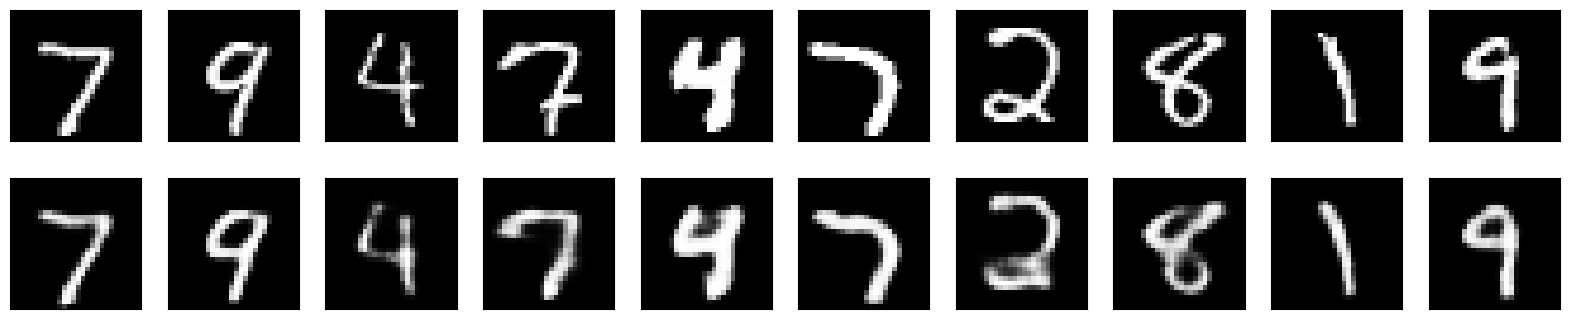

In [28]:
decoded_imgs= ae_decoder.predict(encoded_imgs)
deoceded_images = Ae_conv.predict(x_test)
print("Recreated image Representation of Shape {} using Decoder and reduced Image representation of shape {}".format (decoded_imgs.shape,
                                                                                                                      encoded_imgs.shape))
n = 10  # how many digits we will display
k= 12 # multiplier
plt.figure(figsize=(20,4))
for i in range(n):
  ax=plt.subplot(2,n,i+1)
  plt.imshow(x_test[i*k].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
      # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i*k].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()



